## Загрузка библиотек

Здесь все как в [практике 2](https://colab.research.google.com/drive/1-0eknp0Qd4d2LxauhNwSZB4_Tb44UlJI?usp=share_link), но без подробностей.

In [ ]:
import os
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [ ]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"nataliaafonina","key":"362b1fa4088ddc6937c685ff961b6ccf"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
%%capture
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip

## Загрузка данных

Для колаборативной фильтрации нам понадобятся только айди пользователей, айди книжек и оценки, которые пользователи дали книжкам.

In [ ]:
ratings = pd.read_csv("Ratings.csv")
ratings.shape

(1149780, 3)

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Приведем айди книжек в числовой вид.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(ratings["ISBN"].tolist())
ratings["ISBN"] = le.transform(ratings["ISBN"])
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,57188,0
1,276726,29750,5
2,276727,107392,0
3,276729,127253,3
4,276729,127287,6


In [ ]:
rating_non_zero = ratings[ratings["Book-Rating"] > 0]

In [ ]:
rating_non_zero.shape

(433671, 3)

## Рекоммендации с помощью pyspark

In [ ]:
ratings_spark = spark.createDataFrame(ratings)

In [ ]:
data_spark = (ratings_spark
    .select(
        'User-ID',
        'ISBN',
        'Book-Rating',
    )
).cache()

In [ ]:
(training, test) = data_spark.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                predictionCol="prediction")

mae = evaluator.evaluate(predictions)
print("MAE = " + str(mae))

Root-mean-square error = 4.666126064002115
MAE = 2.7026720491073943


In [ ]:
predictions.show()

+-------+----+-----------+-------------+
|User-ID|ISBN|Book-Rating|   prediction|
+-------+----+-----------+-------------+
| 181817|   0|          6|          0.0|
| 238557|  23|          0|          0.0|
|  11676|  38|          0|          0.0|
|  90148|  40|          0|          0.0|
|  13874|  44|         10| 3.3714547E-5|
| 218187|  61|          9|-1.5144024E-5|
| 275650|  61|          0|  3.988348E-6|
|  71285|  61|          0| 7.3098425E-5|
| 214319|  61|          0| 1.8910649E-6|
| 107899|  62|          0| 1.6261085E-5|
|  20859|  62|          0|          0.0|
| 120548|  64|          0| 0.0011038732|
|  71285|  64|          0|  8.719808E-5|
| 137348|  65|          7|          0.0|
|  85772|  66|          7|-3.8124304E-6|
| 236727|  74|          0|-2.2221604E-5|
| 268423|  91|          8|          0.0|
|  11776|  91|          8|          0.0|
|  11944| 121|          9| 0.0014549654|
|  23902| 123|          8| 0.0010884729|
+-------+----+-----------+-------------+
only showing top

In [ ]:
ratings_spark_0 = spark.createDataFrame(rating_non_zero)

In [ ]:
data_spark_0 = (ratings_spark_0
    .select(
        'User-ID',
        'ISBN',
        'Book-Rating',
    )
).cache()

In [ ]:
(training, test) = data_spark_0.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                predictionCol="prediction")

mae = evaluator.evaluate(predictions)
print("MAE = " + str(mae))

Root-mean-square error = 7.882783808104803
MAE = 7.673238748723926


## Рекоммендации с помощью surprise

In [ ]:
%%capture
!pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

algo = SVD()
reader = Reader(rating_scale=(0, 11))
data = Dataset.load_from_df(ratings[["User-ID", "ISBN", "Book-Rating"]], reader)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.5102  3.5028  3.5074  3.4939  3.4975  3.5024  0.0061  
MAE (testset)     2.8220  2.8152  2.8208  2.8104  2.8122  2.8161  0.0046  
Fit time          57.47   32.33   32.75   33.06   33.28   37.78   9.85    
Test time         3.42    2.57    2.17    3.67    3.72    3.11    0.63    


{'test_rmse': array([3.51021073, 3.50279986, 3.50740996, 3.49387398, 3.49748405]),
 'test_mae': array([2.82200399, 2.81519641, 2.82082834, 2.81037235, 2.81216706]),
 'fit_time': (57.47108197212219,
  32.33341956138611,
  32.74641156196594,
  33.05614137649536,
  33.28413367271423),
 'test_time': (3.41996169090271,
  2.569528102874756,
  2.1696736812591553,
  3.666555166244507,
  3.7232589721679688)}

Видим, что обе реализации справляются с задачей рекоммендации на этом датасете, но не слишком хорошо. Рейтинг изменяется в диапазоне от 0 до 10, а обе модели ошибаются примерно на 2.5. Однако SVD работает чуть стабильней относительно ALS.

## Задание на лабораторную работу 1

В примерах были рассмотрены два варианта рекомендаций посредством колаборативной фильтрации. В качестве практического задания вам предлагается использовать содержание датасетов, чтобы предсказывать, какую оценку пользователь поставит книге.

Для этого представим задачу предсказания оценки как задачу регрессии, где целевой переменной будет признак Book-Rating.
Тогда план анализа данных будет следующим:
1. Предобработать данные: преобразовать все категориальные данные в числовые (для преобразования названий книжек в вектор попробуйте 3 подхода: [bag-of-words](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage), [tf-idf](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), [word2vec](https://radimrehurek.com/gensim/models/word2vec.html), обработать пустые ячейки и неточности в столбцах.
2. Сделать нормировку данных.
3. Обучить и протестировать не менее трех моделей регрессии. Например, [линейную регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [случайный лес](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) и [xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training). Можно также попробовать применить нейронную сеть. Например, по этому [туториалу](https://www.tensorflow.org/tutorials/keras/regression).
4. Оценить результаты (RMSE, MAE).

In [ ]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
rating_non_zero = ratings[ratings["Book-Rating"] > 0]
books_ratings = pd.merge(
    books, rating_non_zero,
    left_on='ISBN',
    right_on='ISBN',
    how='inner'
)
books_ratings = books_ratings[['ISBN', 'Book-Title', 'User-ID', 'Book-Rating']]


In [ ]:
books_ratings

,ISBN,Book-Title,User-ID,Book-Rating
0,0002005018,Clara Callan,8,5
1,0002005018,Clara Callan,11676,8
2,0002005018,Clara Callan,67544,8
3,0002005018,Clara Callan,116866,9
4,0002005018,Clara Callan,123629,9
...,...,...,...,...
383837,0395264707,Dreamsnake,275318,10
383838,1845170423,Cocktail Classics,275970,7
383839,0449906736,Flashpoints: Promise and Peril in a New World,276313,5
383840,0440400988,There's a Bat in Bunk Five,276463,7


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(books_ratings["ISBN"].tolist())
books_ratings["ISBN"] = le.transform(books_ratings["ISBN"])
books_ratings.head()

,ISBN,Book-Title,User-ID,Book-Rating
0,39,Clara Callan,8,5
1,39,Clara Callan,11676,8
2,39,Clara Callan,67544,8
3,39,Clara Callan,116866,9
4,39,Clara Callan,123629,9


In [ ]:
books_ratings['Book-Title'] = books_ratings['Book-Title'].str.replace('\W', ' ', regex=True)

In [ ]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         383842 non-null  int64 
 1   Book-Title   383842 non-null  object
 2   User-ID      383842 non-null  int64 
 3   Book-Rating  383842 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 14.6+ MB


In [ ]:
books_ratings['Book-Rating'].describe()

count    383842.000000
mean          7.626701
std           1.841339
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

In [ ]:
books_ratings.duplicated().any()

False

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

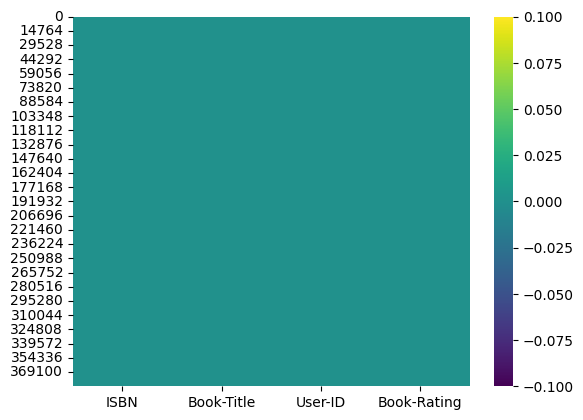

In [ ]:
sns.heatmap(books_ratings.isnull(), cmap='viridis')

Нет повторяющихся или пустых значений.

Text(0, 0.5, 'Frequency')

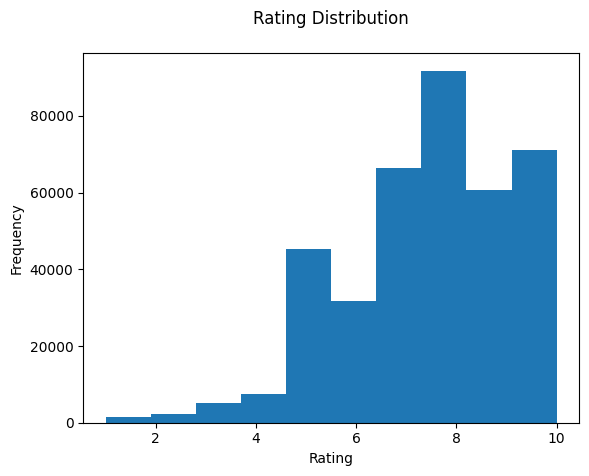

In [ ]:
plt.hist(books_ratings['Book-Rating'])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# preprocessing

Необходимо преобразовать все категориальные данные в числовые. Для начала необходимо токенизировать.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def preprocess_text(text):
    tokenized = nltk.word_tokenize(text)  # Токенизация
    punct = string.punctuation + "—" + "«" + "»"  # Пунктуация
    tokens = [token.lower() for token in tokenized if token not in punct]  # Удаление пунктуации и приведение к нижнему регистру
    stopwords_list = stopwords.words("english")  # Список стоп-слов для английского языка
    tokens = [word for word in tokens if word not in stopwords_list]  # Удаление стоп-слов
    return tokens

books_ratings['Processed-Book-Title'] = books_ratings['Book-Title'].apply(preprocess_text)


In [ ]:
books_ratings['Processed-Book-Title'] = books_ratings['Processed-Book-Title'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
import random
random.seed(42)
books_ratings.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Processed-Book-Title
355547,145202,Ojos De Fuego,188764,6,ojos de fuego
232452,53917,Searching for Caleb,71188,7,searching caleb
269811,69519,Family Under the Bridge,119364,5,family bridge
371924,133320,Vacations Can Be Murder The Second Charlie Pa...,146113,8,vacations murder second charlie parker mystery...
346254,138423,FÃ Â¼r immer und ewig Eine Art Reigen,123956,7,fã â¼r immer und ewig eine art reigen
369954,16547,Little monster s Mother Goose,248496,9,little monster mother goose
213098,134863,Twist tropique,222912,8,twist tropique
41463,81153,Lies My Teacher Told Me Everything Your Amer...,89551,8,lies teacher told everything american history ...
154173,76351,PARTNERSHIP Brainship,7346,8,partnership brainship
205055,40155,The Demon Haunted World Science As a Candle i...,207924,10,demon haunted world science candle dark


In [ ]:
books_ratings.head()

,ISBN,Book-Title,User-ID,Book-Rating,Processed-Book-Title
0,39,Clara Callan,8,5,clara callan
1,39,Clara Callan,11676,8,clara callan
2,39,Clara Callan,67544,8,clara callan
3,39,Clara Callan,116866,9,clara callan
4,39,Clara Callan,123629,9,clara callan


# bag-of-words

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(books_ratings['Processed-Book-Title'])

X_text = vectorizer.transform(books_ratings['Processed-Book-Title'])

print(X_text[0].toarray())

[[0 0 0 ... 0 0 0]]


In [ ]:
from scipy.sparse import hstack

X = X_text
y = books_ratings['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_linreg = model.predict(X_test)

mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

print(f"MSE: {mse_linreg}")
print(f"RMSE: {rmse_linreg}")
print(f"MAE: {mae_linreg}")

MSE: 3.8069945885818175
RMSE: 1.951152118257779
MAE: 1.528157501465861


In [ ]:
y_pred_all_linreg = model.predict(X)

books_ratings_linreg = books_ratings.copy()
books_ratings_linreg['Predicted-Book-Rating'] = y_pred_all_linreg
books_ratings_linreg = books_ratings_linreg.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
341960,74020,The Old Neighborhood A Novel,107784,5,7.505493
87408,48846,A Wrinkle in Time,95359,10,8.864199
133302,86847,Brick Lane A Novel,148258,7,6.863554
71384,42854,Fire Ice A Novel from the NUMA Files,29408,7,7.622204
48883,48042,The King of Torts,197405,6,7.521176
206037,82814,Love Poems,195904,7,7.785336
281871,126557,Expanding Our Now The Story of Open Space Tec...,51132,10,9.501061
349566,63326,Ice,245963,4,7.596173
98887,66716,A Thin Dark Line Mysteries amp Horror,224039,7,7.764436
55218,46020,Harry Potter and the Chamber of Secrets Book 2,21014,9,8.735122


In [ ]:
title_counts = books_ratings_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = books_ratings_linreg[books_ratings_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,8.153996
9808,21945,The Lovely Bones A Novel,277752,7,8.153996
9809,21945,The Lovely Bones A Novel,278633,9,8.153996
9810,21945,The Lovely Bones A Novel,638,10,8.153996
9811,21945,The Lovely Bones A Novel,709,3,8.153996


In [ ]:
books_ratings_linreg.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
0,39,Clara Callan,8,5,7.720711
1,39,Clara Callan,11676,8,7.720711
2,39,Clara Callan,67544,8,7.720711
3,39,Clara Callan,116866,9,7.720711
4,39,Clara Callan,123629,9,7.720711


xgboost

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")

MSE: 3.300510902031069
RMSE: 1.8167308281721508
MAE: 1.4722699130299945


In [ ]:
y_pred_all_xgb = xgb_model.predict(X)
books_ratings_xgb = books_ratings.copy()
books_ratings_xgb['Predicted-Book-Rating'] = y_pred_all_xgb
books_ratings_xgb = books_ratings_xgb.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
297897,26493,The Amber Room,98391,10,7.608725
72660,50284,Another Dawn,4385,10,7.608725
172200,86637,The Bone Vault A Novel,87505,8,7.608725
142874,121110,Chicken Soup for the Couple s Soul Chicken So...,232766,9,7.608725
46765,59860,The Cat Who Blew the Whistle,53265,10,7.608725
223598,73221,Thrill,52509,3,7.608725
184892,73645,Salem s Lot,272225,10,7.608725
201551,86498,An Hour Before Daylight,225274,7,7.608725
111499,117975,A Fine Balance,42180,8,7.608725
276430,20581,Emergency True Stories from the Nation s Ers...,74651,9,7.608725


In [ ]:
title_counts = books_ratings_xgb['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = books_ratings_xgb[books_ratings_xgb['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,7.866868
9808,21945,The Lovely Bones A Novel,277752,7,7.866868
9809,21945,The Lovely Bones A Novel,278633,9,7.866868
9810,21945,The Lovely Bones A Novel,638,10,7.866868
9811,21945,The Lovely Bones A Novel,709,3,7.866868


In [ ]:
books_ratings_xgb.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
0,39,Clara Callan,8,5,7.608725
1,39,Clara Callan,11676,8,7.608725
2,39,Clara Callan,67544,8,7.608725
3,39,Clara Callan,116866,9,7.608725
4,39,Clara Callan,123629,9,7.608725


knn

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"MSE: {mse_knn}")
print(f"RMSE: {rmse_knn}")
print(f"MAE: {mae_knn}")

MSE: 3.7456910992718417
RMSE: 1.9353787999437841
MAE: 1.538636689288645


In [ ]:
y_pred_all_knn = knn_model.predict(X)
books_ratings_knn = books_ratings.copy()
books_ratings_knn['Predicted-Book-Rating'] = y_pred_all_knn
books_ratings_knn = books_ratings_knn.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_knn.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
296736,21549,An Unfinished Life John F Kennedy 1917 1963,250494,9,8.2
249211,82900,Skeleton Dance Gideon Oliver Mysteries Hardc...,132942,6,7.2
120054,86814,Fall on Your Knees,29209,7,8.0
11557,47731,Black and Blue,156150,6,6.2
296132,18685,An Unfortunate Woman A Journey,190459,7,7.6
21162,47560,The Rainmaker,190185,9,7.2
245490,140242,Alles Sense Ein Scheibenwelt Roman,153869,10,9.2
244847,82196,The Curse of the Egyptian Mummy,119364,5,7.2
87502,121074,Chicken Soup for the Soul at Work Chicken Sou...,42929,8,8.0
315277,39531,Science and the Founding Fathers Science in t...,107258,9,7.8


In [ ]:
books_ratings_knn.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
0,39,Clara Callan,8,5,7.4
1,39,Clara Callan,11676,8,7.4
2,39,Clara Callan,67544,8,7.4
3,39,Clara Callan,116866,9,7.4
4,39,Clara Callan,123629,9,7.4


In [ ]:
title_counts = books_ratings_knn['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = books_ratings_knn[books_ratings_knn['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,9.0
9808,21945,The Lovely Bones A Novel,277752,7,9.0
9809,21945,The Lovely Bones A Novel,278633,9,9.0
9810,21945,The Lovely Bones A Novel,638,10,9.0
9811,21945,The Lovely Bones A Novel,709,3,9.0


# tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(binary=True)
X_text_tfidf = tfidf_vectorizer.fit_transform(books_ratings['Processed-Book-Title'])

In [ ]:
print(X_text_tfidf[0].toarray())

[[0. 0. 0. ... 0. 0. 0.]]


In [ ]:
X_tfidf = X_text_tfidf
y_tfidf = books_ratings['Book-Rating']

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_linreg = model.predict(X_test_tfidf)

mse_tfidf_linreg = mean_squared_error(y_test_tfidf, y_pred_tfidf_linreg)
rmse_tfidf_linreg = np.sqrt(mse_linreg)
mae_tfidf_linreg = mean_absolute_error(y_test_tfidf, y_pred_tfidf_linreg)

print(f"MSE: {mse_tfidf_linreg}")
print(f"RMSE: {rmse_tfidf_linreg}")
print(f"MAE: {mae_tfidf_linreg}")

MSE: 3.7353221802942693
RMSE: 1.951152118257779
MAE: 1.5186196641249303


In [ ]:
y_pred_tfidf_all_linreg = model.predict(X_tfidf)
books_ratings_tfidf_linreg = books_ratings.copy()
books_ratings_tfidf_linreg['Predicted-Book-Rating'] = y_pred_tfidf_all_linreg
books_ratings_tfidf_linreg = books_ratings_tfidf_linreg.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_tfidf_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
358274,52089,Banner Red and Gold,248718,8,8.065363
80566,42889,Portrait of a Killer Jack the Ripper Case ...,17726,7,6.425131
39018,70084,Black Beauty Apple Classics,1674,10,7.607500
307038,19163,Good Books Lately The One Stop Resource for ...,98391,9,8.464959
168418,48448,Ramona and Her Mother Ramona Quimby Paperback,163307,7,8.505957
181260,6564,The Secret Garden,197866,8,7.984406
33882,21218,One for the Money A Stephanie Plum Novel,208492,10,8.138009
123120,14080,Sons and Lovers Oxford World s Classics,11811,9,7.504720
48551,82106,ANGELA S ASHES,175206,6,8.459021
18539,40370,All the Pretty Horses Border Trilogy Vol 1,638,8,7.652384


In [ ]:
books_ratings_tfidf_linreg.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
0,39,Clara Callan,8,5,7.717231
1,39,Clara Callan,11676,8,7.717231
2,39,Clara Callan,67544,8,7.717231
3,39,Clara Callan,116866,9,7.717231
4,39,Clara Callan,123629,9,7.717231


In [ ]:
title_counts = books_ratings_tfidf_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = books_ratings_tfidf_linreg[books_ratings_tfidf_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,8.14805
9808,21945,The Lovely Bones A Novel,277752,7,8.14805
9809,21945,The Lovely Bones A Novel,278633,9,8.14805
9810,21945,The Lovely Bones A Novel,638,10,8.14805
9811,21945,The Lovely Bones A Novel,709,3,8.14805


xgboost

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_xgb = xgb_model.predict(X_test_tfidf)

mse_tfidf_xgb = mean_squared_error(y_test_tfidf, y_pred_tfidf_xgb)
rmse_tfidf_xgb = np.sqrt(mse_xgb)
mae_tfidf_xgb = mean_absolute_error(y_test_tfidf, y_pred_tfidf_xgb)

print(f"MSE: {mse_tfidf_xgb}")
print(f"RMSE: {rmse_tfidf_xgb}")
print(f"MAE: {mae_tfidf_xgb}")

MSE: 3.299677157728709
RMSE: 1.8167308281721508
MAE: 1.4719908529793255


In [ ]:
y_pred_tfidf_all_xgb = xgb_model.predict(X_tfidf)
books_ratings_tfidf_xgb = books_ratings.copy()
books_ratings_tfidf_xgb['Predicted-Book-Rating'] = y_pred_tfidf_all_xgb
books_ratings_tfidf_xgb = books_ratings_tfidf_xgb.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_tfidf_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
316077,36601,Tiger Lily,70415,9,7.609547
7207,12694,Life of Pi,273718,7,7.776237
105063,100870,It s My F ing Birthday A Novel,61912,7,7.609547
70056,21893,The Pilot s Wife A Novel,189973,7,7.587605
55274,46020,Harry Potter and the Chamber of Secrets Book 2,104636,10,8.751675
209036,54236,How to Drive Your Man Wild in Bed,23902,7,7.609547
347340,12251,Orlando Penguin Modern Classics,97324,9,7.629767
137875,94087,Joy Shtick or What is the Existential Vacuum a...,144667,3,7.609547
327103,33644,This New Ocean The Story of the First Space ...,189835,5,7.201857
312322,104466,A Bouquet of Love An Arrangement of Four Bea...,100256,6,7.609547


In [ ]:
books_ratings_tfidf_xgb.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
0,39,Clara Callan,8,5,7.609547
1,39,Clara Callan,11676,8,7.609547
2,39,Clara Callan,67544,8,7.609547
3,39,Clara Callan,116866,9,7.609547
4,39,Clara Callan,123629,9,7.609547


In [ ]:
result = books_ratings_tfidf_xgb[books_ratings_tfidf_xgb['ISBN'] == 46020]
result.head(10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
55208,46020,Harry Potter and the Chamber of Secrets Book 2,278356,8,8.751675
55209,46020,Harry Potter and the Chamber of Secrets Book 2,254,9,8.751675
55210,46020,Harry Potter and the Chamber of Secrets Book 2,4896,10,8.751675
55211,46020,Harry Potter and the Chamber of Secrets Book 2,8245,8,8.751675
55212,46020,Harry Potter and the Chamber of Secrets Book 2,10560,10,8.751675
55213,46020,Harry Potter and the Chamber of Secrets Book 2,11676,8,8.751675
55214,46020,Harry Potter and the Chamber of Secrets Book 2,12824,8,8.751675
55215,46020,Harry Potter and the Chamber of Secrets Book 2,16181,10,8.751675
55216,46020,Harry Potter and the Chamber of Secrets Book 2,17667,7,8.751675
55217,46020,Harry Potter and the Chamber of Secrets Book 2,19336,9,8.751675


KNN

In [ ]:
knn_tfidf_model = KNeighborsRegressor(n_neighbors=5)

knn_tfidf_model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_knn = knn_tfidf_model.predict(X_test_tfidf)

mse_tfidf_knn = mean_squared_error(y_test_tfidf, y_pred_tfidf_knn)
rmse_tfidf_knn = np.sqrt(mse_knn)
mae_tfidf_knn = mean_absolute_error(y_test_tfidf, y_pred_tfidf_knn)

print(f"MSE: {mse_tfidf_knn}")
print(f"RMSE: {rmse_tfidf_knn}")
print(f"MAE: {mae_tfidf_knn}")

MSE: 3.6272969558024726
RMSE: 1.9353787999437841
MAE: 1.5172452422201672


In [ ]:
y_pred_tfidf_all_knn = knn_tfidf_model.predict(X_tfidf)
books_ratings_tfidf_knn = books_ratings.copy()
books_ratings_tfidf_knn['Predicted-Book-Rating'] = y_pred_tfidf_all_knn
books_ratings_tfidf_knn = books_ratings_tfidf_knn.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_tfidf_knn.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
52910,67220,Final Target,230762,6,7.8
336433,32484,Irons in the Fire,183744,6,8.6
293280,10170,The Magic Toyshop,232266,8,8.0
339794,148384,Roteiro lÃ rico e sentimental da cidade do Rio...,83096,8,7.6
161723,35229,Gentle Rogue Malory Novels Paperback,242006,10,8.8
137451,13572,Sophocles The Oedipus Cycle Oedipus Rex Oed...,186570,10,8.6
173926,55871,Anna s Book,14521,8,8.2
347432,14378,The Tibetan Book of the Dead Or the After De...,230211,8,7.6
343297,144299,PÃ Â¼nktchen und Anton Ein Roman fÃ Â¼r Kinde...,132826,9,8.4
235522,25832,The Hunger Moon Ballantine Readers Circle,264917,7,8.6


In [ ]:
books_ratings_tfidf_knn.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
0,39,Clara Callan,8,5,7.4
1,39,Clara Callan,11676,8,7.4
2,39,Clara Callan,67544,8,7.4
3,39,Clara Callan,116866,9,7.4
4,39,Clara Callan,123629,9,7.4


In [ ]:
result = books_ratings_tfidf_xgb[books_ratings_tfidf_xgb['ISBN'] == 46020]
result.head(10)

,ISBN,Book-Title,User-ID,Book-Rating,Predicted-Book-Rating
55208,46020,Harry Potter and the Chamber of Secrets Book 2,278356,8,8.751675
55209,46020,Harry Potter and the Chamber of Secrets Book 2,254,9,8.751675
55210,46020,Harry Potter and the Chamber of Secrets Book 2,4896,10,8.751675
55211,46020,Harry Potter and the Chamber of Secrets Book 2,8245,8,8.751675
55212,46020,Harry Potter and the Chamber of Secrets Book 2,10560,10,8.751675
55213,46020,Harry Potter and the Chamber of Secrets Book 2,11676,8,8.751675
55214,46020,Harry Potter and the Chamber of Secrets Book 2,12824,8,8.751675
55215,46020,Harry Potter and the Chamber of Secrets Book 2,16181,10,8.751675
55216,46020,Harry Potter and the Chamber of Secrets Book 2,17667,7,8.751675
55217,46020,Harry Potter and the Chamber of Secrets Book 2,19336,9,8.751675


# word2vec

In [ ]:
books_ratings['Processed-Book-Title'].unique()

array(['clara callan', 'decision normandy',
       'flu story great influenza pandemic 1918 search virus caused', ...,
       'cocktail classics', 'flashpoints promise peril new world',
       'one one hundred'], dtype=object)

In [ ]:
import urllib.request # библиотека для скачивания данных
import gensim # библиотека для загрузки и использвоания моделй w2v
from gensim.models import word2vec # непосредственно методы w2v
from gensim.models import Word2Vec

In [ ]:
preprocessed_corpus = books_ratings['Processed-Book-Title'].apply(lambda text: text.split())
model = Word2Vec(sentences=preprocessed_corpus, vector_size=100, window=5, min_count=1, workers=4)

vectors = []

title_vector = np.mean([model.wv[word] for word in books_ratings['Processed-Book-Title'] if word in model.wv], axis = 0)

In [ ]:
books_ratings['Title_Vector'] = books_ratings['Processed-Book-Title'].apply(
    lambda title: np.mean([model.wv[word] for word in title.split() if word in model.wv], axis=0)
)

In [ ]:
max_length = books_ratings['Title_Vector'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0).max()

books_ratings['Title_Vector'] = books_ratings['Title_Vector'].apply(lambda x: np.pad(x, (0, max_length - len(x))) if isinstance(x, (list, np.ndarray)) else x)

In [ ]:
import numpy as np

# Фильтрация строк с нулевой длиной вектора
zero_length_rows = books_ratings[books_ratings['Title_Vector'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0) == 0]

# Заполнение значений векторов нулями
for index in zero_length_rows.index:
    books_ratings.at[index, 'Title_Vector'] = np.zeros(100)


In [ ]:
max_length = books_ratings['Title_Vector'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0).max()
min_length = books_ratings['Title_Vector'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0).min()

print(max_length, min_length)

100 100


In [ ]:
vector_lengths = books_ratings['Title_Vector'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)
unique_lengths = vector_lengths.nunique()

if unique_lengths == 1:
    print("Все векторы имеют одинаковую длину.")
else:
    print("Длины векторов различны.")


Все векторы имеют одинаковую длину.




> Линейная регрессия



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Преобразование 'Title_Vector' в матрицу
X = np.array(books_ratings['Title_Vector'].tolist())

# Выделение целевой переменной 'Book-Rating'
y = books_ratings['Book-Rating']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test_scaled)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 3.341109274682701
RMSE: 1.8278701471063805
MAE: 1.4781177071179252


In [ ]:
y_pred_all_linreg = model.predict(X)

books_ratings_linreg = books_ratings.copy()
books_ratings_linreg['Predicted-Book-Rating'] = y_pred_all_linreg
books_ratings_linreg = books_ratings_linreg.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
325537,25253,My Love Affair with England A Traveler s Memoir,78846,8,"[-0.117371656, 0.14270405, 0.36440718, -0.8679...",7.733472
104602,87226,Good in Bed,228311,6,"[-0.21028638, -0.07882847, -0.15672229, 0.1853...",7.622936
215,47857,The Testament,276641,6,"[0.23616493, -0.21342388, 0.18382572, 0.137353...",7.813787
70899,55827,The Dividing Line Joshua Rabb Novels,4149,7,"[-0.7151285, 0.041739814, 0.9808911, -0.101987...",7.647551
319747,20468,Dead Girls,188618,8,"[-0.23423621, -0.5054213, 0.41936275, 0.082784...",7.523276
300032,133999,The Boyne and Aughrim The War of the Two King...,63765,9,"[0.021877378, -0.3650725, 0.42004037, -0.40055...",7.741928
58501,81724,Hearts In Atlantis New Fiction,131254,7,"[-0.5538538, 0.3031655, 1.091974, -0.6925508, ...",7.684389
111192,46478,Harry Potter and the Chamber of Secrets Book 2,98440,10,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.089663
293345,51413,Sewer Gas amp Electric THE PUBLIC WORKS T...,172700,8,"[-1.3139772, 0.016027372, 0.4844758, 0.0784358...",7.936254
177546,147414,Tres Habitaciones En Manhattan,95902,8,"[0.3570997, -0.5474415, -0.23030251, 0.1572135...",7.677372




> xgboost


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")

MSE: 3.2627545881122235
RMSE: 1.806309660083847
MAE: 1.4563488863121001


In [ ]:
y_pred_all_xgb = xgb_model.predict(X)
books_ratings_xgb = books_ratings.copy()
books_ratings_xgb['Predicted-Book-Rating'] = y_pred_all_xgb
books_ratings_xgb = books_ratings_xgb.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
259277,67032,A Wicked Way to Burn,38931,6,"[-0.20465045, -0.12240746, 0.39487687, -0.1984...",7.731699
363067,122296,D2 The Mighty Ducks Are Back,251422,5,"[0.39948153, -0.14355059, -0.10359603, -0.1699...",7.670485
349356,99678,Hasan,187747,6,"[-0.006022351, 0.004277022, -0.0060482263, 0.0...",7.656177
377216,13221,The Object Stares Back On the Nature of Seeing,26939,6,"[0.34333163, -0.21770063, -0.18093811, -0.2819...",7.747881
11616,57484,Le Divorce William Abrahams Book,170558,9,"[-0.21751764, -0.86004335, 0.92643535, -0.0362...",7.978709
136096,26304,Until Dark,143294,9,"[-0.7558757, -1.3645786, -0.46457303, -1.17960...",8.000578
380518,61912,Pooh s Bedtime Book,211426,10,"[-0.5621779, -0.30165002, 0.661189, -0.0949634...",7.966703
87847,33236,Straight Man A Novel Vintage Contemporaries,275970,8,"[-0.51456165, 0.016292136, 0.0799881, -0.43279...",7.788379
223376,94126,The Grand Complication A Novel,56198,5,"[-0.85376495, -0.2096145, 0.43005744, 1.023026...",7.691391
190186,36218,Tex amp Molly in Afterlife,51962,9,"[-1.0094063, 0.54172546, -0.0479378, 0.2001870...",7.800097


In [ ]:
title_counts = books_ratings_xgb['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = books_ratings_xgb[books_ratings_xgb['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"[-0.26482737, -0.23745388, 0.98747283, 1.05692...",7.801216
9808,21945,The Lovely Bones A Novel,277752,7,"[-0.26482737, -0.23745388, 0.98747283, 1.05692...",7.801216
9809,21945,The Lovely Bones A Novel,278633,9,"[-0.26482737, -0.23745388, 0.98747283, 1.05692...",7.801216
9810,21945,The Lovely Bones A Novel,638,10,"[-0.26482737, -0.23745388, 0.98747283, 1.05692...",7.801216
9811,21945,The Lovely Bones A Novel,709,3,"[-0.26482737, -0.23745388, 0.98747283, 1.05692...",7.801216


In [ ]:
books_ratings_xgb.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
0,39,Clara Callan,8,5,"[0.053964633, -0.14423376, 0.18792967, 0.04689...",7.662628
1,39,Clara Callan,11676,8,"[0.053964633, -0.14423376, 0.18792967, 0.04689...",7.662628
2,39,Clara Callan,67544,8,"[0.053964633, -0.14423376, 0.18792967, 0.04689...",7.662628
3,39,Clara Callan,116866,9,"[0.053964633, -0.14423376, 0.18792967, 0.04689...",7.662628
4,39,Clara Callan,123629,9,"[0.053964633, -0.14423376, 0.18792967, 0.04689...",7.662628




> knn



In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"MSE: {mse_knn}")
print(f"RMSE: {rmse_knn}")
print(f"MAE: {mae_knn}")

MSE: 3.751851398350897
RMSE: 1.9369696431154766
MAE: 1.5408485195847281


In [ ]:
y_pred_all_knn = knn_model.predict(X)
books_ratings_knn = books_ratings.copy()
books_ratings_knn['Predicted-Book-Rating'] = y_pred_all_knn
books_ratings_knn = books_ratings_knn.drop('Processed-Book-Title', axis=1)

In [ ]:
random.seed(42)
books_ratings_knn.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
153479,111309,Prophet,190741,9,"[0.11132902, -0.12980276, 0.62007797, 0.047063...",9.2
37568,32242,Reversible Errors A Novel,72190,6,"[-0.73225945, 0.31824756, 0.21723257, 0.393509...",8.6
7219,62355,Lies and the Lying Liars Who Tell Them A Fair...,16009,9,"[-0.13648574, 0.2964236, 0.0891541, 0.13851461...",9.6
221289,39367,Part of My Soul Went With Him,272887,10,"[-0.012157877, -0.18907696, 0.18670993, -0.340...",8.6
152866,38010,The Cottage,150932,10,"[-0.036939114, -0.08378857, 0.34568316, 0.1706...",8.2
120951,26272,Big Cherry Holler A Big Stone Gap Novel Ball...,168500,8,"[0.06978018, -0.10562651, 0.014869323, 0.18780...",6.4
201238,121052,Chicken Soup for the Soul Chicken Soup for th...,91130,6,"[0.014890049, -0.7151766, 0.84946847, -0.75577...",7.6
339214,127328,The Prisoner of Second Avenue starring Rich...,189835,5,"[0.14785784, -0.119051285, 0.33440846, 0.16504...",7.2
328757,94489,The Complete Book of Necromancers Advanced Du...,177458,8,"[-0.2890536, -0.32766804, 0.28117177, -0.31884...",8.2
72931,106140,Understanding Your Personality,224525,10,"[0.10138713, 0.01722154, -0.12217759, -0.84823...",8.8


In [ ]:
books_ratings_knn.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
0,39,Clara Callan,8,5,"[0.0076554706, -0.14930393, 0.22912171, 0.0264...",9.0
1,39,Clara Callan,11676,8,"[0.0076554706, -0.14930393, 0.22912171, 0.0264...",9.0
2,39,Clara Callan,67544,8,"[0.0076554706, -0.14930393, 0.22912171, 0.0264...",9.0
3,39,Clara Callan,116866,9,"[0.0076554706, -0.14930393, 0.22912171, 0.0264...",9.0
4,39,Clara Callan,123629,9,"[0.0076554706, -0.14930393, 0.22912171, 0.0264...",9.0


In [ ]:
result = books_ratings_xgb[books_ratings_xgb['ISBN'] == 46020]
result.head(10)

,ISBN,Book-Title,User-ID,Book-Rating,Title_Vector,Predicted-Book-Rating
55208,46020,Harry Potter and the Chamber of Secrets Book 2,278356,8,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55209,46020,Harry Potter and the Chamber of Secrets Book 2,254,9,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55210,46020,Harry Potter and the Chamber of Secrets Book 2,4896,10,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55211,46020,Harry Potter and the Chamber of Secrets Book 2,8245,8,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55212,46020,Harry Potter and the Chamber of Secrets Book 2,10560,10,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55213,46020,Harry Potter and the Chamber of Secrets Book 2,11676,8,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55214,46020,Harry Potter and the Chamber of Secrets Book 2,12824,8,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55215,46020,Harry Potter and the Chamber of Secrets Book 2,16181,10,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55216,46020,Harry Potter and the Chamber of Secrets Book 2,17667,7,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
55217,46020,Harry Potter and the Chamber of Secrets Book 2,19336,9,"[-0.069357574, -0.8047683, -0.14787121, 0.8565...",8.149333
